## Importando os dados

In [1]:
import pandas as pd
import numpy as np

instances = pd.read_csv("tic_tac_toe.csv", index_col=False)

## Preprocessando os dados

In [2]:
instances = instances.sample(frac=1, random_state=1).reset_index(drop=True)

inputs = instances.iloc[:, :-1].replace("x", 0).replace("o", 1).replace("b", 2).to_numpy()
outputs = instances.iloc[:, -1].replace("positive", 1).replace("negative", 0).to_numpy()

## Definição da função de plotar resultados

In [3]:
import matplotlib.pyplot as plt

def pretty_plot(all_metrics, metric_info, texts, x_tick_labels):
    stats = []
    for m in metric_info:
        stats.append(np.array([s[m["name"]] for s in all_metrics]))
        
    xs = np.linspace(0, stats[0].shape[0] - 1, stats[0].shape[0])
    
    errorbar_style = {"linestyle":"--", "linewidth":1, "markeredgewidth":2, "elinewidth":2, "capsize":3, "marker": "^"}
    plot_style = {"linestyle":"--", "linewidth":1, "markeredgewidth":2, "marker": "^"}
    
    fig = plt.figure(figsize=(12, 8))

    ax = [plt.subplot(2, 1, i + 1) for i in range(len(metric_info))]
    
    colors = ["#e74c3c", "#2ecc71"]
    
    for i, m in enumerate(metric_info):
        curr_color = colors[i % len(colors)]
        if m["type"] == "error":               
            ax[i].errorbar(xs, stats[i].mean(axis=1), stats[i].std(axis=1), **errorbar_style, color=curr_color)
        elif m["type"] == "simple":
            if m["format"] == "mean":
                ax[i].plot(xs, stats[i].mean(axis=1), **plot_style, color=curr_color)
            elif m["format"] == "single":
                ax[i].plot(xs, stats[i], **plot_style, color=curr_color)
             
        ax[i].xaxis.set_ticks(xs)
        ax[i].set_xticklabels(x_tick_labels)
        ax[i].set_title(texts[i]["title"])
        ax[i].set_xlabel("Boosting Iterations")
        ax[i].set_ylabel(texts[i]["ylabel"])

    plt.tight_layout()
    plt.show()

## Experimentos testando acurácia e F1

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from boosting_classifier import BoostingClassifier

all_metrics = []
all_iterations = list(range(3, 15))

for iterations in all_iterations:
    fold_metrics = {"accuracy": [], "f1": []}
    
    kf = KFold(n_splits=5)
    for train_i, test_i in kf.split(inputs):
        train_x_data, train_y_data = inputs[train_i], outputs[train_i]
        test_x_data, test_y_data = inputs[test_i], outputs[test_i]

        b_model = BoostingClassifier(iterations=iterations)
        b_model.fit(train_x_data, train_y_data)
        
        y_pred = b_model.predict(test_x_data)
        
        fold_metrics["accuracy"].append(accuracy_score(test_y_data, y_pred))
        fold_metrics["f1"].append(f1_score(test_y_data, y_pred))
        
    all_metrics.append(fold_metrics)
    
pretty_plot(all_metrics, [
    { "name": "accuracy", "type": "error", "format": "mean" },
    { "name": "f1", "type": "simple", "format": "mean" }
], [
    { "title": "Accuracy over 5 folds / hyperparameter", "ylabel": "Accuracy 5-fold average / std" },
    { "title": "F1 over 5 folds / hyperparameter", "ylabel": "F1 5-fold avg" },
], all_iterations)

## Experimentos testando variância e viés

1 {'bias': 0.36666666666666664, 'variance': 0.0}
3 {'bias': 0.36666666666666664, 'variance': 0.0}
5 {'bias': 0.4125, 'variance': 0.14681249999999998}
7 {'bias': 0.4708333333333333, 'variance': 0.11627083333333332}
9 {'bias': 0.4125, 'variance': 0.11083333333333334}
11 {'bias': 0.375, 'variance': 0.11479166666666665}
13 {'bias': 0.3625, 'variance': 0.10883333333333332}
15 {'bias': 0.325, 'variance': 0.1143125}


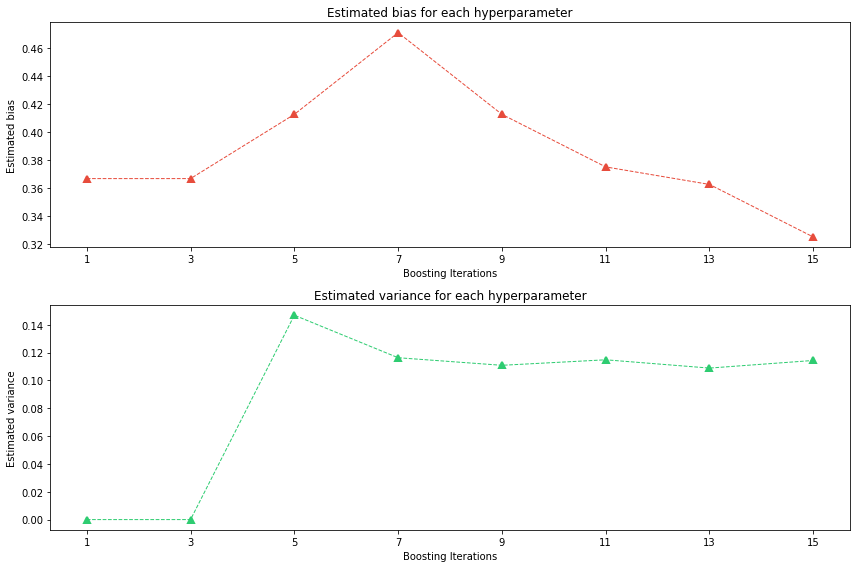

In [4]:
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import bias_variance_decomp
from boosting_classifier import BoostingClassifier

x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.25, random_state=1)

all_metrics = []
all_iterations = list(range(1, 16, 2))

for iteration in all_iterations:
    model = BoostingClassifier(iterations=iteration)
    _, bias, var = bias_variance_decomp(model, x_train, y_train,x_test, y_test, num_rounds=200, random_seed=1)
    print(iteration, { "bias": bias, "variance": var })
    all_metrics.append({ "bias": bias, "variance": var })

pretty_plot(all_metrics, [
    { "name": "bias", "type": "simple", "format": "single" },
    { "name": "variance", "type": "simple", "format": "single" }
], [
    { "title": "Estimated bias for each hyperparameter", "ylabel": "Estimated bias" },
    { "title": "Estimated variance for each hyperparameter", "ylabel": "Estimated variance" },
], all_iterations)